## Import libraries & notebook configuration

In [25]:
import os
import pyxdf # xdf file importation
import matplotlib.pyplot as plt
import numpy as np
import nbformat #used to call other scripts
from my_functions import *

# library for creating filters
from scipy.signal import butter, iirnotch, filtfilt, welch
#%matplotlib widget

### Ensure that the root directory is the project directory
In some cases, the root directory may not be the project directory. This is usually the case when the notebook is run from a subdirectory of the project directory.

In [26]:
# if pwd is SRC  change to root
print("Current working directory: ", os.getcwd())
if os.path.basename(os.getcwd()) == "SRC":
    os.chdir("..")
print("Current working directory: ", os.getcwd())
print(os.path.basename(os.getcwd()))

Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Stage_Signal_Physio


In [27]:
plt.close("all")  # close all figure windows

## Initialization

### Xdf file selection and loading (REARM data)

In [28]:
# Define the xdf file of interest
xdf_input_filename="001_MolLud_20201112_1_c.xdf"
#xdf_filename="020_DesMar_20211129_1_c.xdf"

xdf_input_filepath=os.path.normpath("DAT/INPUT/"+xdf_input_filename)

### Convert xdf eeg data to csv

In [29]:
#option to process the signal before export to csv (detrending,rereferencing,filtering) (bool)
PROCESS_SIGNAL= True

#Execute the exportation of the EEG data in xdf file to csv, returns output filename
csv_input_filename = export_xdf_eeg_to_csv(xdf_input_filepath,PROCESS_SIGNAL) 


Input filepath:  DAT\INPUT\001_MolLud_20201112_1_c.xdf
Input filename:  001_MolLud_20201112_1_c
PROCESS_SIGNAL ? -- True
--Processing signals
Detrending...
input_signals shape:
 (221938, 8)
input_signals mean per signal:
 [27897.195 26144.139 28026.402 35319.527 31324.672 24827.713 32372.799
 29788.95 ]
Rereferencing...
input_signals shape:(221938, 8)
input_signals whole mean:13.818697929382324
Filtering...
LOW_CUTOFF_FREQ_THEORETICAL=5,HIGH_CU-TOFF_FREQ_THEORETICAL=100
LOW_CUTOFF_FREQ_CORRECTED=4.732,HIGH_CUTOFF_FREQ_CORRECTED=104.203
NOTCH_CUTOFF_FREQ=50
Filtered signal shape: (221938, 8)
EEG_for_export shape : (221938, 8)
--Exporting
export data header : Channel_1:C4, Channel_2:FC2, Channel_3:FC6, Channel_4:CP2, Channel_5:C3, Channel_6:FC1, Channel_7:FC5, Channel_8:CP1,time(sec)
Input filepath : DAT\INPUT\001_MolLud_20201112_1_c.xdf
Output filepath : DAT\INPUT\001_MolLud_20201112_1_c_prepro_499.998_Hz.csv


### Load corresponding csv file

In [30]:
csv_input_filepath=os.path.normpath("DAT/INPUT/"+csv_input_filename)
print(csv_input_filepath)
EEG_data= np.genfromtxt(csv_input_filepath, delimiter=',',skip_header=1)

DAT\INPUT\001_MolLud_20201112_1_c_prepro_499.998_Hz.csv


### Tidy data

In [31]:
EEG_amplitudes=EEG_data[:,0:8] #first 8 columns are channels
EEG_times=EEG_data[:,8] #last is absolute time in sec
Srate=500
#N=len(EEG_amplitudes)

## Study 1 - PSD estimation results on whole signals : Electrode C3 and C4 

In [32]:
# definition of the EEG channels' names
channels_dict = {"Channel_1": "C4",
                "Channel_2": "FC2",
                "Channel_3": "FC6",
                "Channel_4": "CP2",
                "Channel_5": "C3",
                "Channel_6": "FC1",
                "Channel_7": "FC5",
                "Channel_8": "CP1"}

### Electrode selection

In [33]:
# Selection of electrodes to study
SELECT_CHANNEL_NUMBERS=np.array([1,5])

### Time signals and event markers

In [34]:
#retrieve the event markers
markers_array=create_marker_times_labels_array(xdf_input_filepath=xdf_input_filepath)
nearest_markers_array=nearest_timestamps_array_finder(EEG_times_stamps=EEG_times,markers=markers_array)

#Display channel numbers and corresponding names
print(channels_dict)

MARKERS LEN: 12
{'Channel_1': 'C4', 'Channel_2': 'FC2', 'Channel_3': 'FC6', 'Channel_4': 'CP2', 'Channel_5': 'C3', 'Channel_6': 'FC1', 'Channel_7': 'FC5', 'Channel_8': 'CP1'}


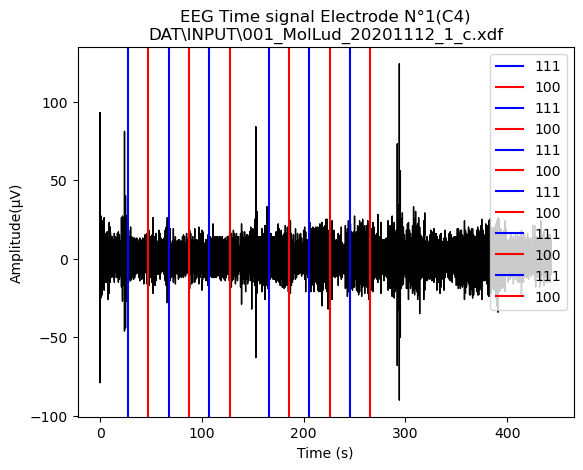

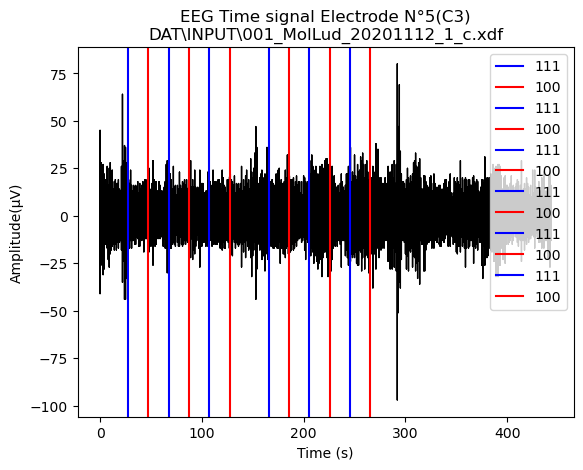

In [35]:
for iter,i in enumerate(SELECT_CHANNEL_NUMBERS):
    Channel_index=i-1
    single_plot(f"{xdf_input_filepath}", fig_number=iter, x=EEG_times, y=EEG_amplitudes[:, Channel_index],
            fig_title=f"EEG Time signal Electrode N°{i}({channels_dict[f'Channel_{i}']})",
            xlabel="Time (s)", ylabel="Amplitude(µV)",markers_times_array=markers_array
            )

### PSD estimations over entire signals

selected channels :
channel number:1, channel index:0
Channel_1_C4
channel number:5, channel index:4
Channel_5_C3
matlab psd results file names: ['MATLAB_PSD_res_EEG_Channel_1_C4_001_MolLud_20201112_1_c_prepro_499.998_Hz.csv', 'MATLAB_PSD_res_EEG_Channel_5_C3_001_MolLud_20201112_1_c_prepro_499.998_Hz.csv']
channel name: Channel_1_C4
001_MolLud_20201112_1_c_prepro_499.998_Hz.csv
 MATLAB_PSD_res_EEG_Channel_1_C4_001_MolLud_20201112_1_c_prepro_499.998_Hz.csv 
 Channel_1_C4
N:  221938
duration:  443.876
time_vector shape:  (221938,)
signal_frequency_vector before crop len:110970,half_val: 125.00112644071767
signal_frequency_vector last freq : 250.0
./DAT/OUTPUT/Matlab_PSD_Results/MATLAB_PSD_res_EEG_Channel_1_C4_001_MolLud_20201112_1_c_prepro_499.998_Hz.csv <class 'str'>
len psd matlab fft:110970
channel name: Channel_5_C3
001_MolLud_20201112_1_c_prepro_499.998_Hz.csv
 MATLAB_PSD_res_EEG_Channel_5_C3_001_MolLud_20201112_1_c_prepro_499.998_Hz.csv 
 Channel_5_C3
N:  221938
duration:  443.876


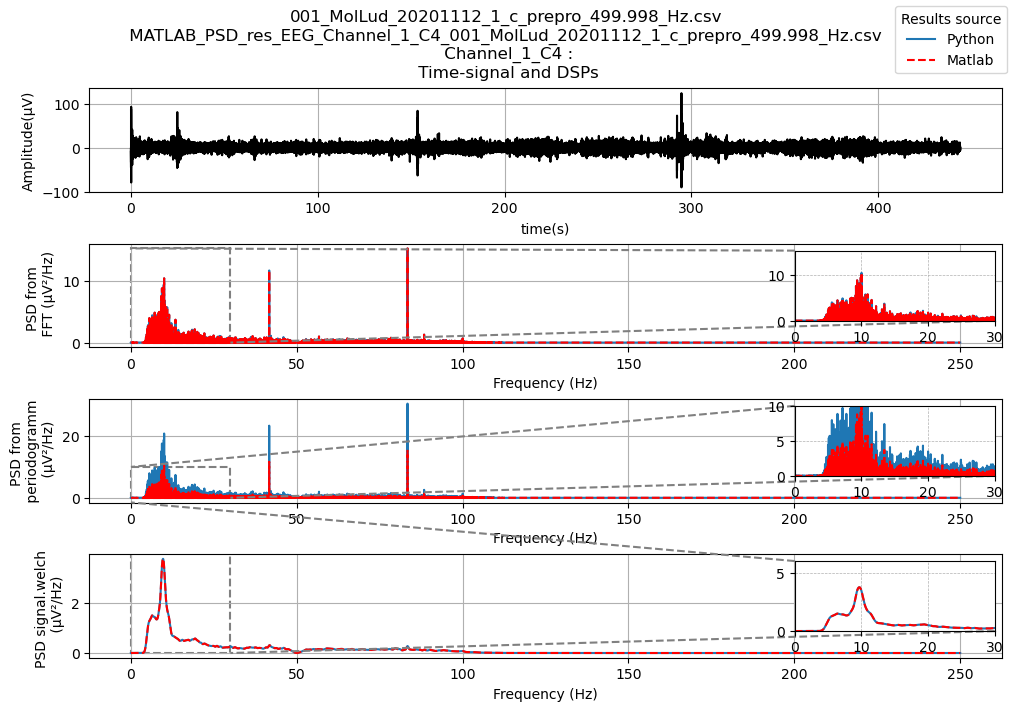

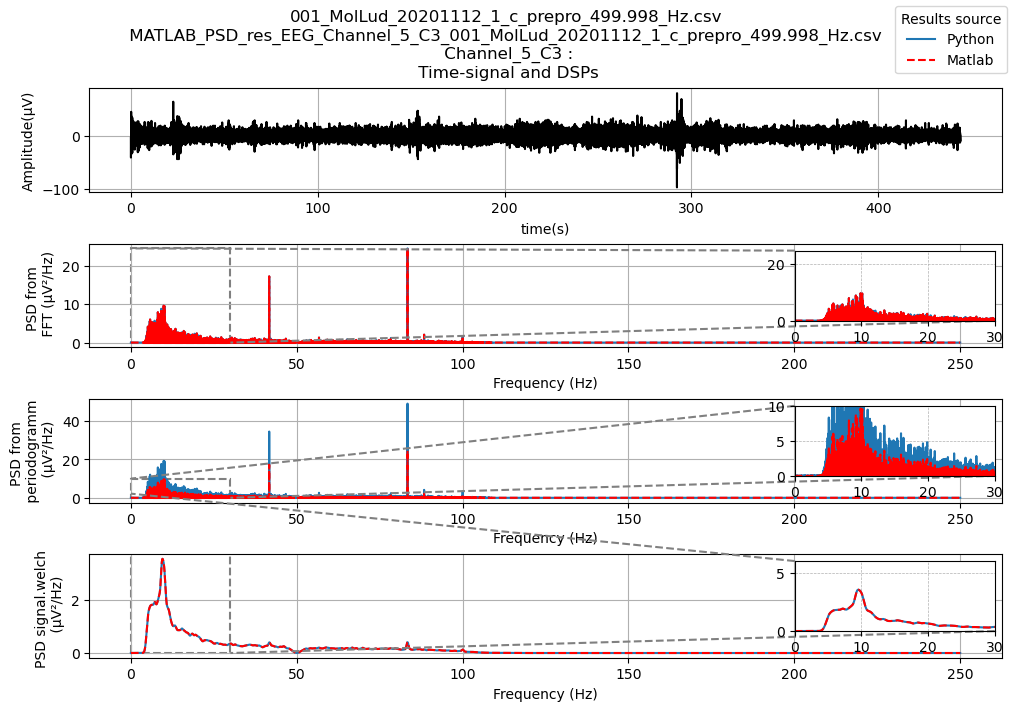

In [36]:

PSD_results=plot_multi_signal_time_dsps(multi_channel_signals=EEG_amplitudes, sample_rate=Srate,
                                 channels_dict=channels_dict, selected_channel_numbers=SELECT_CHANNEL_NUMBERS,
                                input_signal_filename=csv_input_filename)

### <span style="color:red">Analysis 1</span>

<u>Context:</u><br>
001_MolLud_20201112_1_c is an eeg recording of a control "healthy" subject during a motor assessment protocol based on the "circular steering task" .

In this protocol, the subject is asked to use a computer mouse do the following:
- at trigger 111: perform the circular movement for 20s. 
- at trigger 100: rest for the same amount of time. </br>

<b>One phase of circular movement followed by one rest phase is a trial: </br>
1 trial = 1 movement period (111 epoch) + 1 rest period (100 epoch) </b>

The subject is asked to repeat the trial 3 times successively for an arm (making 1 set). There are 2 sets per subject (1 for each arm) and the subject should do the 1st set with its left arm, and the 2nd with its right arm. </br>

<b>Set 1 = left arm solicitation (3 trials), Set 2 = right arm solicitation (3 trials) </br></b>

The EEG recording starts before the first set and ends after the 2nd one. To study the effect of the motor task performed on one arm, we can start by studying the contralateral electrode' signal (C4 for set 1(left arm), c3 for set 2( right arm))

For an initial overview, the DSPs shown above were all calculated over the entire recording from start to finish (containing the two sets in addition to moments where subject's behavior is not controlled). The signals were not epoched. We only consider the DSPs obtained using the welch method as they will be used to compute the ERSP in the future.

<u>Study 1</u><br>
We can see:
- That for both electrodes, the main power spectral peak is located between 8-12 Hz. 
- That in this frequency band (8-12 Hz), the power peak of electrode C4 looks more saillent than C5's.
- That for both elecrodes, between 12-20Hz no clear peak is visible, but the amplitude stays greater than at frequencies over 20Hz.

The litterature says:
1. The frequency of brain oscillations is negatively correlated with their amplitude (cf.source 1).

2. Voluntary movement induced by a stimulus induces variations in the synchronization of cortical rhythms that are time locked but non-phase locked. They can be detected by spectral analysis, and manifest by power changes in specific frequency bands. One indicator is the ERSP, which reflects the spectral power changes relative to an event. Depending on the orientation of the power change, two types of ERSP are distinguished: 
    - Event-Related Desynchronization (ERD): if the event induces a reduction in power in a specific frequency band
    - Event-Related Synchronization (ERS): if the event induces an augmentation in power in a specific frequency band

3. In experimental conditions, when a trigger tells subjects to perform a movement with either side of the body, ERSPs are expected over their contralateral motor cortex in the following sequence (cf. sources):
    - During the reaction time, wherein the subject is planning to execute/imagine the movement:
        - In the Alpha band (8-12 Hz) (ie. Rolandic/Mu rythm): An ERD is expected. (cf. source 1)
        - in the beta band (12-20 Hz) : an ERD is also expected. (cf source 1)
    - During the execution of the movement:
        - In the Alpha band (8-12 Hz) : An ERD is expected (cf source 1,4)
        - In the beta band (12-20 Hz) : An ERD is expected.
    - After movement offset (1s after)
        - Reduction of the Mu ERD
        - Beta band (12-20Hz): An ERS called "beta rebound" (cf.source 1,4).
- sources:
    1. [Pfurtscheller G, Lopes da Silva FH](https://doi.org/10.1016/s1388-2457(99)00141-8) ERSP basic principles P6-9
    2. [Muller, C.O., Muthalib, M., Mottet, D. et al. Recovering](https://doi.org/10.1186/s13063-021-05689-5) P65-65
    3. [Nakayashiki, K., Saeki, M., Takata, Y. et al](https://doi.org/10.1186/1743-0003-11-90)
    5. [Yongwoong Jeon, Chang S. Nam, Young-Joo Kim, Min Cheol Whang,](https://doi.org/10.1016/j.ergon.2011.03.005) ERD/ERS: implications for BCIs

<u>Conclusion</u>:
- Overall, the results show that the amplitudes are decreasing when frequency increases (8-12Hz,12-20Hz,>20Hz)
- The salient spectral peaks in the alpha/mu frequency band for C3 and C4 suggests that something is happening in these frequency bands over the motor regions during the experiment.
- Thus, The DSP results of the EEG recording performed on a healthy subject during an the "circular steering task" paradigm are coherent with the literature results in similar conditions.

<u>Perspectives</u>:
- We can take a closer look to our C3,C4 time signals and their PSDs to see how the motor task may effect on the spectral power in these frequency bands.
- To do that, we can epoch the signals using the task and rest event triggers to define the 111 and 100 epochs respectively. Thus, we can compute the PSDs of each epoch and compare them for a specific set to study the effect of the motor task on the power spectrum in these frequency bands.
- To see if the results are reproductible, we could also average the PSDs of the 111 and 100 epochs's separately for a given sequence, giving us 3 trials for each.


## Study 2 - PSD estimations over rest and task periods for electrode C3 & C4 

### Electrode C3

In [37]:
#Select channel to study
Channel_num=5 #electrode C3
Channel_index=Channel_num-1 #cf python indexing

#channel signal retrieval
electrode_i_signal=EEG_amplitudes[:,Channel_index] 

#epoch signal
electrode_i_epoched_signal=extract_data_epochs(signal=electrode_i_signal,sample_rate=Srate,markers_labels_times=nearest_markers_array,
                                    select_events=(111,100),epoch_limits=(0,4))

#compute all epochs' PSDs
leng=electrode_i_epoched_signal["label_111"]["signal_segments"].shape[0]
psd_for_each_100_epoch=compute_psds_for_each_epoch(epochs=electrode_i_epoched_signal["label_100"]["signal_segments"],sample_rate=Srate,nfft=leng)
psd_for_each_111_epoch=compute_psds_for_each_epoch(epochs=electrode_i_epoched_signal["label_111"]["signal_segments"],sample_rate=Srate,nfft=leng)

Epoch limits relative to events (in sec): before: 0s - after: 4s
Epoch limits relative to events (in samples): n_points_before_marker: 0 - n_points_after_marker: 2000
Event type : 111 ------------ epochs :
first_seg_coord: 13500 - second_seg_coord: 15500
first_seg_coord: 33500 - second_seg_coord: 35500
first_seg_coord: 53500 - second_seg_coord: 55500
first_seg_coord: 83000 - second_seg_coord: 85000
first_seg_coord: 103000 - second_seg_coord: 105000
first_seg_coord: 123000 - second_seg_coord: 125000
signal_segments shape: (2001, 6)
time_segments shape: (2001, 6)
Event type : 100 ------------ epochs :
first_seg_coord: 23500 - second_seg_coord: 25500
first_seg_coord: 43500 - second_seg_coord: 45500
first_seg_coord: 63500 - second_seg_coord: 65500
first_seg_coord: 93000 - second_seg_coord: 95000
first_seg_coord: 113000 - second_seg_coord: 115000
first_seg_coord: 133000 - second_seg_coord: 135000
signal_segments shape: (2001, 6)
time_segments shape: (2001, 6)
segments shapes to psd - (2001,

#### Select epoch number

In [38]:
#Select trial number
epoch_number=3
epoch_index=epoch_number-1

#### Trial i: Show rest (100) and motor task (111) epochs' time signals and their PSDs

signals to compare shape - (2001, 2)
segments shapes to psd - (2001, 2)


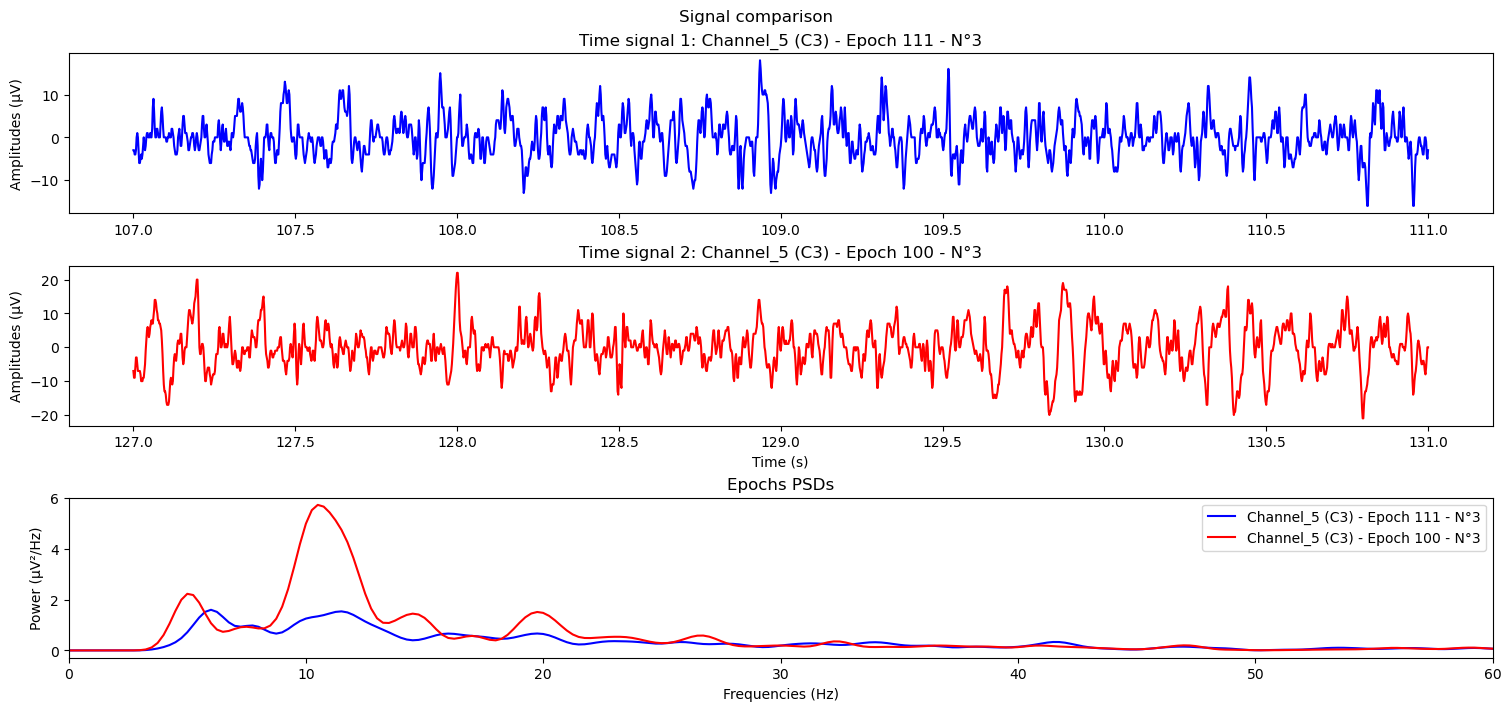

In [39]:
channel_name=f"Channel_{Channel_num}"
signal1=np.column_stack((electrode_i_epoched_signal["label_111"]["time_segments"][:,epoch_index],electrode_i_epoched_signal["label_111"]["signal_segments"][:,epoch_index]))
signal2=np.column_stack((electrode_i_epoched_signal["label_100"]["time_segments"][:,epoch_index],electrode_i_epoched_signal["label_100"]["signal_segments"][:,epoch_index]))
my_labels=(f"{channel_name} ({channels_dict[channel_name]}) - Epoch 111 - N°{epoch_number}",
           f"{channel_name} ({channels_dict[channel_name]}) - Epoch 100 - N°{epoch_number}")

signal_comparison(signal_1=signal1,signal_2=signal2,sample_rate=Srate,labels=my_labels)


### Average PSDs per epoch type

In [40]:
trial_range_111=slice(3,6) #select bloc 2's trials
trial_range_100=slice(3,6) #select bloc 2's trials

#Select epochs
c4_111_trials=electrode_i_epoched_signal["label_111"]["signal_segments"][:,trial_range_111] #Only 3 trials compose the 1st block (left arm sollicitation) that interest us for electrode C4 (right hemisphere)
c4_100_trials=electrode_i_epoched_signal["label_100"]["signal_segments"][:,trial_range_100] #all 6 trials as the rest periods are the same

#compute PSD average of selected epochs
N=c4_111_trials.shape[0] #both epoch type(111,100) signals have the same duration/length
c4_frequencies111,c4_mean_pxx111=compute_averaged_psds_over_trials(c4_111_trials,sample_rate=Srate,nfft=N)
c4_frequencies100,c4_mean_pxx100=compute_averaged_psds_over_trials(c4_100_trials,sample_rate=Srate,nfft=N)

segments shapes to psd - (2001, 3)
segments shapes to psd - (2001, 3)


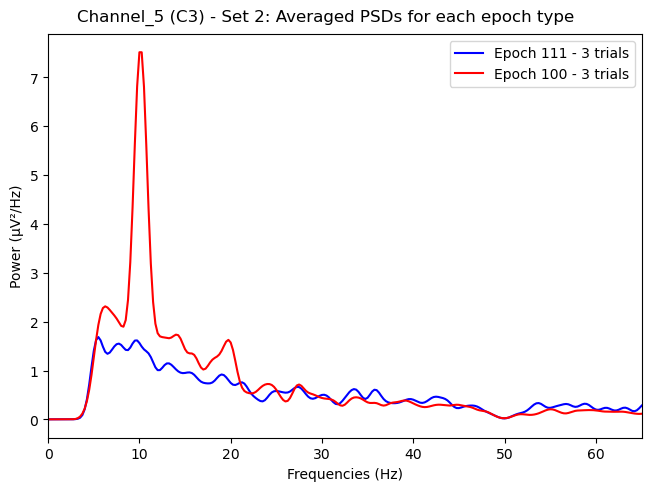

In [41]:
number_trials_111=c4_111_trials.shape[-1] #number of columns
number_trials_100=c4_100_trials.shape[-1]
#Plot results
plt.figure(layout="constrained")
plt.suptitle(f"{channel_name} ({channels_dict[channel_name]}) - Set 2: Averaged PSDs for each epoch type")
plt.plot(c4_frequencies111, c4_mean_pxx111, label=f'Epoch 111 - {number_trials_111} trials', color='blue')

# Plot the second set of data on the same figure
plt.plot(c4_frequencies100, c4_mean_pxx100, label=f'Epoch 100 - {number_trials_100} trials', color='red')
plt.xlim(0,65)

# Add legend and labels
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Power (µV²/Hz)')

# Show the plot
plt.show()


### Electrode C4

In [42]:
#Select channel to study
Channel_num=1 #electrode C4
Channel_index=Channel_num-1 #cf python indexing

#channel signal retrieval
electrode_i_signal=EEG_amplitudes[:,Channel_index] 

#epoch signal
electrode_i_epoched_signal=extract_data_epochs(signal=electrode_i_signal,sample_rate=Srate,markers_labels_times=nearest_markers_array,
                                    select_events=(111,100),epoch_limits=(0,4))

#compute all epochs' PSDs
leng=electrode_i_epoched_signal["label_111"]["signal_segments"].shape[0]
psd_for_each_100_epoch=compute_psds_for_each_epoch(epochs=electrode_i_epoched_signal["label_100"]["signal_segments"],sample_rate=Srate,nfft=leng)
psd_for_each_111_epoch=compute_psds_for_each_epoch(epochs=electrode_i_epoched_signal["label_111"]["signal_segments"],sample_rate=Srate,nfft=leng)

Epoch limits relative to events (in sec): before: 0s - after: 4s
Epoch limits relative to events (in samples): n_points_before_marker: 0 - n_points_after_marker: 2000
Event type : 111 ------------ epochs :
first_seg_coord: 13500 - second_seg_coord: 15500
first_seg_coord: 33500 - second_seg_coord: 35500
first_seg_coord: 53500 - second_seg_coord: 55500
first_seg_coord: 83000 - second_seg_coord: 85000
first_seg_coord: 103000 - second_seg_coord: 105000
first_seg_coord: 123000 - second_seg_coord: 125000
signal_segments shape: (2001, 6)
time_segments shape: (2001, 6)
Event type : 100 ------------ epochs :
first_seg_coord: 23500 - second_seg_coord: 25500
first_seg_coord: 43500 - second_seg_coord: 45500
first_seg_coord: 63500 - second_seg_coord: 65500
first_seg_coord: 93000 - second_seg_coord: 95000
first_seg_coord: 113000 - second_seg_coord: 115000
first_seg_coord: 133000 - second_seg_coord: 135000
signal_segments shape: (2001, 6)
time_segments shape: (2001, 6)
segments shapes to psd - (2001,

#### Select epoch number

In [43]:
#Select trial number
epoch_number=3
epoch_index=epoch_number-1

#### Trial i: Show rest (100) and motor task (111) epochs' time signals and their PSDs

signals to compare shape - (2001, 2)
segments shapes to psd - (2001, 2)


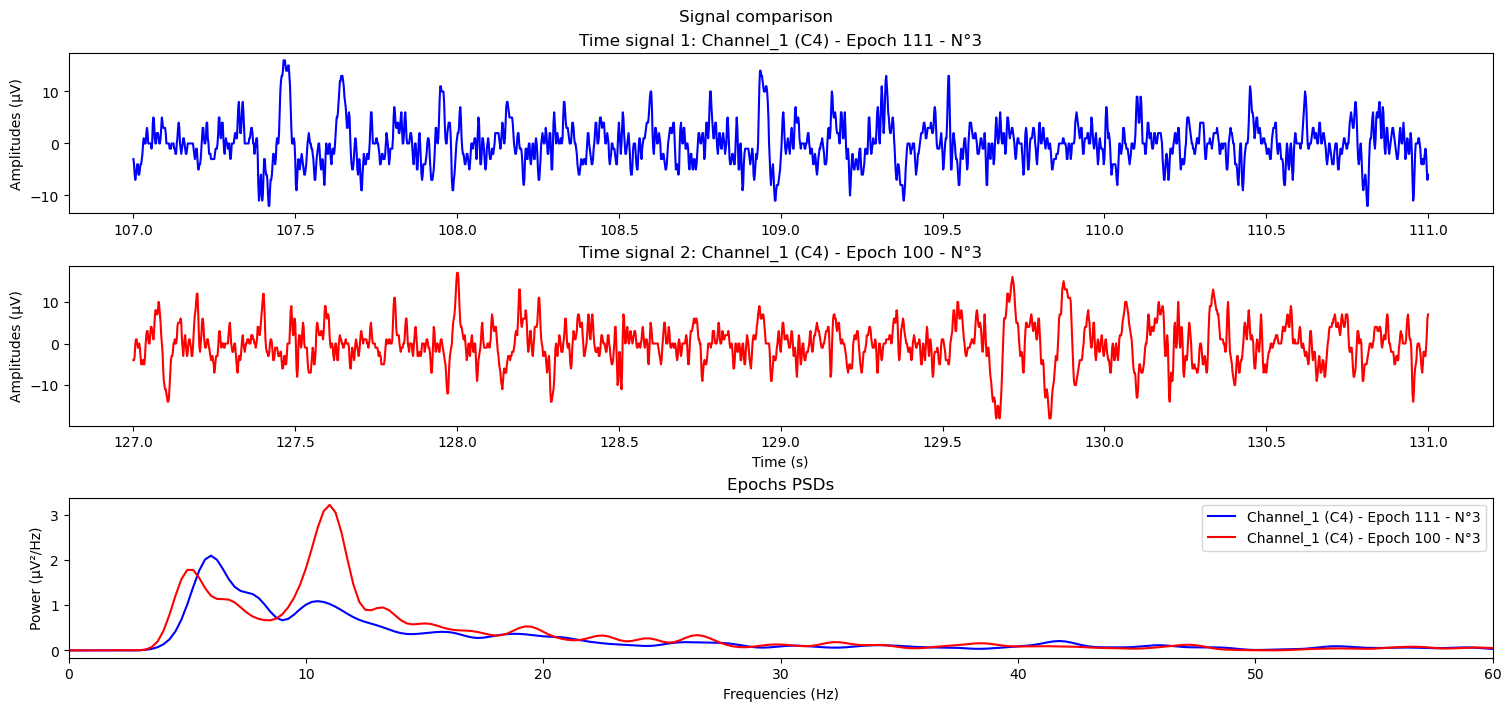

In [44]:
channel_name=f"Channel_{Channel_num}"
signal1=np.column_stack((electrode_i_epoched_signal["label_111"]["time_segments"][:,epoch_index],electrode_i_epoched_signal["label_111"]["signal_segments"][:,epoch_index]))
signal2=np.column_stack((electrode_i_epoched_signal["label_100"]["time_segments"][:,epoch_index],electrode_i_epoched_signal["label_100"]["signal_segments"][:,epoch_index]))
my_labels=(f"{channel_name} ({channels_dict[channel_name]}) - Epoch 111 - N°{epoch_number}",
           f"{channel_name} ({channels_dict[channel_name]}) - Epoch 100 - N°{epoch_number}")

signal_comparison(signal_1=signal1,signal_2=signal2,sample_rate=Srate,labels=my_labels)


In [45]:
trial_range_111=slice(0,3) #select bloc 1's trials
trial_range_100=slice(0,3) #select bloc 1's trials

#Select epochs
c4_111_trials=electrode_i_epoched_signal["label_111"]["signal_segments"][:,trial_range_111] #Only 3 trials compose the 1st block (left arm sollicitation) that interest us for electrode C4 (right hemisphere)
c4_100_trials=electrode_i_epoched_signal["label_100"]["signal_segments"][:,trial_range_100] #all 6 trials as the rest periods are the same

#compute PSD average of selected epochs
N=c4_111_trials.shape[0] #both epoch type(111,100) signals have the same duration/length
c4_frequencies111,c4_mean_pxx111=compute_averaged_psds_over_trials(c4_111_trials,sample_rate=Srate,nfft=N)
c4_frequencies100,c4_mean_pxx100=compute_averaged_psds_over_trials(c4_100_trials,sample_rate=Srate,nfft=N)

segments shapes to psd - (2001, 3)
segments shapes to psd - (2001, 3)


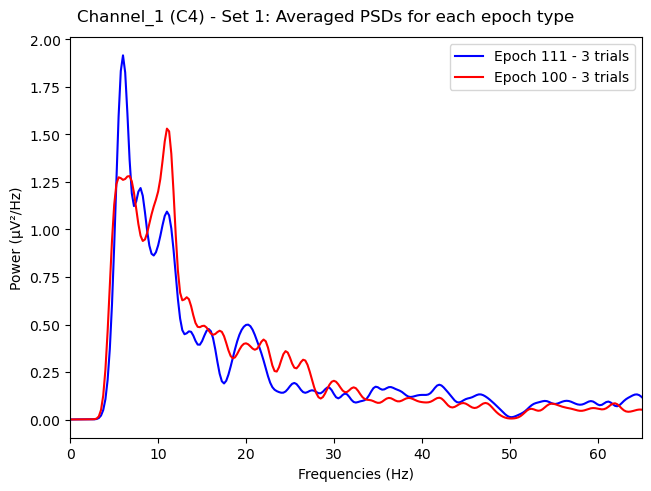

In [46]:
number_trials_111=c4_111_trials.shape[-1] #number of columns
number_trials_100=c4_100_trials.shape[-1]
#Plot results
plt.figure(layout="constrained")
plt.suptitle(f"{channel_name} ({channels_dict[channel_name]}) - Set 1: Averaged PSDs for each epoch type")
plt.plot(c4_frequencies111, c4_mean_pxx111, label=f'Epoch 111 - {number_trials_111} trials', color='blue')

# Plot the second set of data on the same figure
plt.plot(c4_frequencies100, c4_mean_pxx100, label=f'Epoch 100 - {number_trials_100} trials', color='red')
plt.xlim(0,65)

# Add legend and labels
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Power (µV²/Hz)')

# Show the plot
plt.show()


### <span style="color:red">Analysis 2</span>

<u>Context:</u><br>
- Electrode C3 and C4 whole signals' PSDs showed noticeable spectral peaks in the mu frequency band (8-12 Hz) 
- No noticeable peak was found in the low Beta frequency band (12-20Hz) but amplitude stays greater that at frequencies over 20Hz.
- To study the effect of the solicitation of one arm, we must study the data from the corresponding set on the contralateral electrode. Thus, left arm corresponds to set 1 and electrode C4. Right arm corresponds to set 2 and electrode C3.

<u>Study 2</u><br>

<u>Methods:</u><br> 
- For each electrode, we have 6x 111markers, and  6x 100markers, thus we epoched the signal to have 6x 111 epochs and 6x 100 epochs. Each set has 3 trials, thus for each epoch type, the first 3 are from the set N°1, and the 3 last are from the set N°2.
- While each event lasts for 20s, we are only studying the first 4 seconds of the events, all the epochs are then 4 seconds long.
- The averaged PSD graphs were obtained by computing separately the PSD of each epoch, then by averaging the PSDs of epochs of same type over trials.
- The 3 plot figures represents the time signals of the epochs of a trial, and their respective PSD.

<b>Blue and red are used to represent results from epoch type 111 and 100 respectively. </b>

<u>Results:</u></br>

- For <span style= 'background:green'> electrode C3</span>, we study the solicitation of the right arm (contralateral) which corresponds to set N°2:
    - Observations:
        - Set N°2 contains trials 4 to 6.
        - Intra-trial epoch signal comparison:
            - Trial N°3 (displayed) Epoch 100's PSD show two spectral peaks, one major at 8-12Hz (15 µV²/Hz), one minor around 20Hz (2.5 µV²/Hz). No clear peak is visible for epoch 111's corresponding PSD.
            - Trial N°2 displayed similar results except that the amplitude of the first peak was 2 times smaller for epoch 100's PSD.
            - Trial N°1 showed for Epoch 100 and 111 showed a larger first peak (5-10Hz) but no peak around 20Hz.
        - Averaged PSDs (displayed):
            - The averaged PSD of epochs 100 (rest) over all trials of set N°2 shows two spectral peaks: one at 8-12Hz (7 µV²/Hz) and the other around 20Hz (1.9 µV²/Hz) while averaged PSD of epochs 111 does not show specific rhythmic components especially in these frequency bands.
    - Interpretation: 
        - Overall, set N°2 shows that the electrode C3 signal contains 2 main rhythmic components at 8-12Hz and 20 Hz during rest periods that are abolished during right arm solicitation. 

- For <span style= 'background:green'> electrode C4 </span>, we study the solicitation of the left arm (contralateral) which corresponds to set N°1:
    - Observations:
        - Set N°1 contains trials 1 to 3.
        - Intra-trial epoch signal comparison:
            - Trial N°3 (displayed) show in Epoch 100's PSD two spectral peaks, one major at 9-12Hz at 3(µV²/Hz), one minor around at 5-8Hz at 2(µV²/Hz). A clear peak is visible for epoch 111's corresponding PSD at 5-9Hz at 2(µV²/Hz).
            - Trial N°2 showed in epoch 100's PSD that no clear rhythmic component is present in the signal, as multiple peaks are distributed from 7-12Hz to 20 Hz and above. Epoch 111's PSD showed 3 major peaks: at 7 Hz (2.3 µV²/Hz), 11 Hz (1.5 µV²/Hz), and 20 Hz (0.7µV²/Hz).
            - Trial N°1's PSDs for both epoch types did not reveal the presence of any specific rhythmic component as multiple peaks were distributed between 5 to 20 Hz and above.
        - Averaged PSDs (displayed):
            - The averaged PSD of epochs 100 (rest) over all set N°1 trials' shows only one spectral peak at 8-12Hz (1.5 µV²/Hz) while averaged PSD of 111 epochs shows two peaks: one around 7Hz (1.9 µV²/Hz) and one around 20Hz (0.5 µV²/Hz). In all cases, as the amplitudes are low and close to each other, we may consider them to not differ.
    - Interpretation: 
        - On average, set N°1 does not seem to show a clear difference in signal power distribution between rest period and left arm motor solicitation period. In both cases the signal seems to have no rhythmicity in the mu and beta frequency bands.


<u>Conclusions</u>: </br>
Even though 3 trials per set may be few replicates to conclude clearly on the results we may say that:
- Set 2 (right arm) PSD results show that rhythmic components are present in the C3 signal during the first 4 seconds of rest period in both mu and beta frequency bands. These rhythmic components are abolished (or at least reduced) during the first 4 seconds of arm solicitation.
- Set 1 (left arm) PSD results did not reveal any specific rhythmic component in C4 signal during the first 4 seconds of rest period in both mu and beta frequency bands. Same for the first 4 seconds of arm solicitation.
- Thus, the results of the second set tend to replicate Pfurtscheller's results and predictions. Conversely the first set did not replicate the predicted results.
- Note: For both sets, the first trial produced very similar PSD results between epoch 100 and 111.
- Set 2 results may lead us to say that when computing the ERSPs over the first 4 seconds of the event, we may expect to have a ERD in the mu (8-12 Hz) and beta band (12.5-20 Hz) as the power within these frequencies decreases drastically during the motor event. Thus, Matching the results of the litterature mentionned in Analysis 1.

<u>Perspectives</u>:

- As the subject studied here is healthy the fact that the second set tend to replicate the results but not the first one is surprising. Several assumptions may emerge from this assessment, especially if the first set is also his very first:
    - one can be that the subject moved during the first set resting periods.
    - Another one may be that the patient imagined the execution of the task during rest periods.

- To verify these assumptions, we may: 
    - Test the same analysis method on the dataset from another healthy subject to check if the results are consistent amongst healthy subjects
    - Add more replicates to see if the results are consistent for this subject
    - Check if the event markers match the physical movements of the subject 
        - Track mouse movement used to perform the circular task and check if matches the event markers.
        - Track body movement (kinect) if he's not holding the mouse.
    


## PSD results whole signal verification  (matlab vs python)

### Root mean square error (RMSE) of the difference between the python and matlab distributions for each PSD estimation method

In [47]:
for i in SELECT_CHANNEL_NUMBERS:
    channel=f"Channel_{i}"
    channel_fullname=f"{channel}_{channels_dict[channel]}"
    print(channel_fullname)
    # for a channel compute the rms of the difference of two series and print the results
    rms_fft=rms(PSD_results[channel_fullname]["Python_PSD_results"]["PSD_FFT"]["psds"],PSD_results[channel_fullname]["Matlab_PSD_results"]["PSD_FFT"]["psds"],f"rms_fft_{channel}")
    rms_p=rms(PSD_results[channel_fullname]["Python_PSD_results"]["PSD_P"]["psds"],PSD_results[channel_fullname]["Matlab_PSD_results"]["PSD_P"]["psds"],f"rms_p_{channel}")
    rms_w=rms(PSD_results[channel_fullname]["Python_PSD_results"]["PSD_W"]["psds"],PSD_results[channel_fullname]["Matlab_PSD_results"]["PSD_W"]["psds"],f"rms_w_{channel}")

Channel_1_C4
rms_fft_Channel_1 =  3.6247687850490767e-16  (µV²/Hz)
rms_p_Channel_1 =  0.2710671988422232  (µV²/Hz)
rms_w_Channel_1 =  5.684910983384439e-16  (µV²/Hz)
Channel_5_C3
rms_fft_Channel_5 =  4.211471387563797e-16  (µV²/Hz)
rms_p_Channel_5 =  0.3118374395365743  (µV²/Hz)
rms_w_Channel_5 =  6.502954090375546e-16  (µV²/Hz)


### Absolute difference between Python and maltab PSD results for each estimation method

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


iter= 0
Channel_1_C4


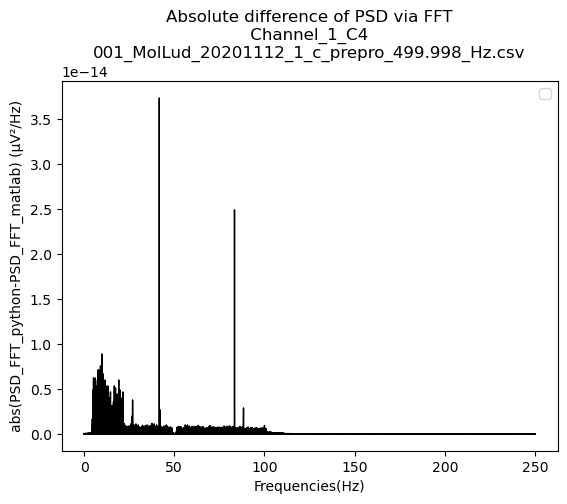

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


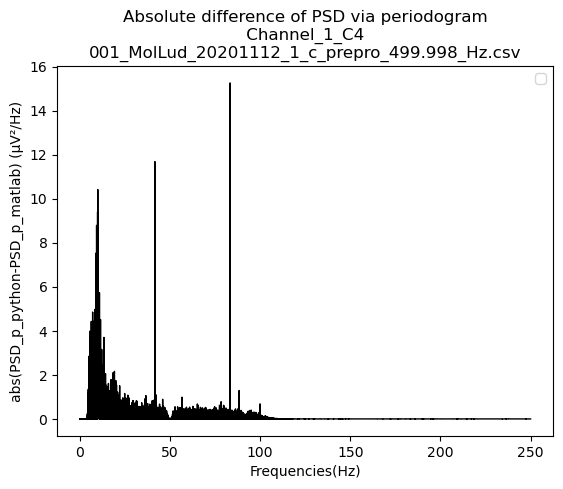

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


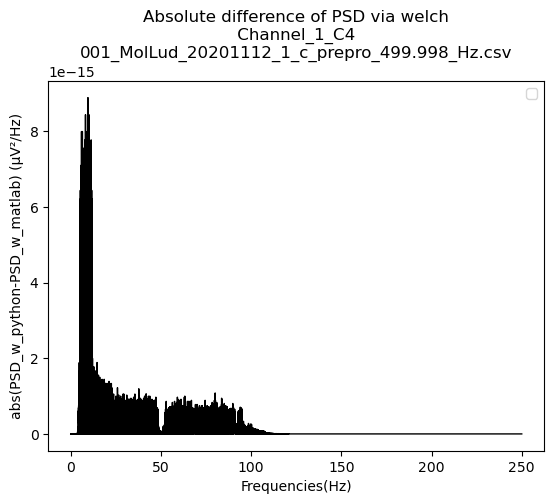

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


iter= 1
Channel_5_C3


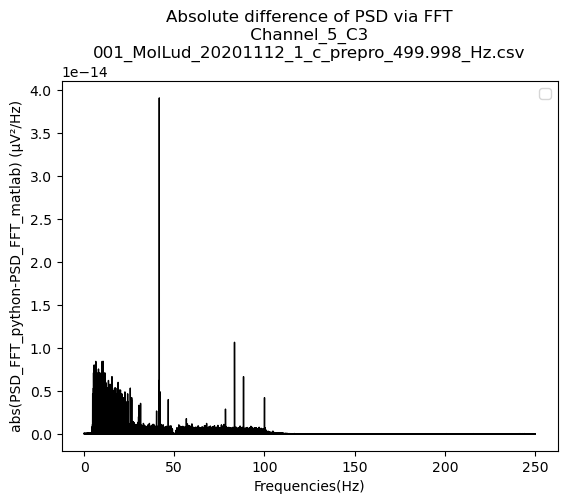

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


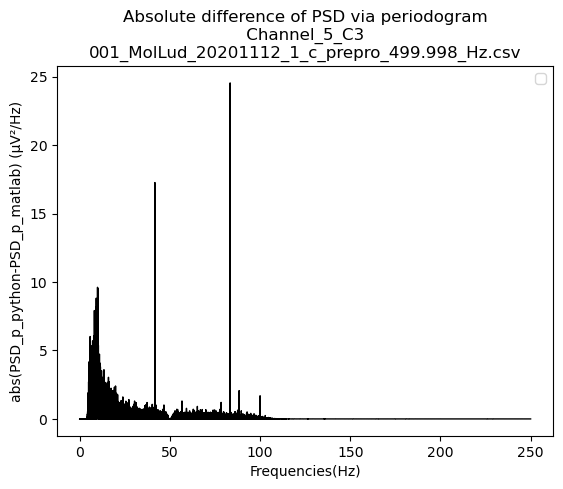

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


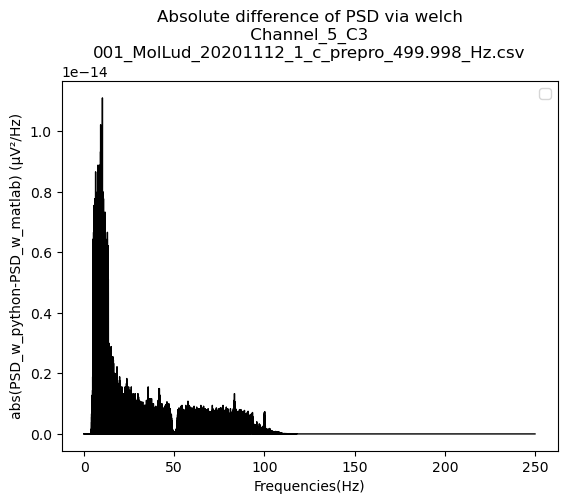

In [48]:
dict={}
for iter,i in enumerate(SELECT_CHANNEL_NUMBERS):
    print("iter=",iter)
    channel=f"Channel_{i}"
    channel_fullname=f"{channel}_{channels_dict[channel]}"
    print(channel_fullname)
    # for a channel compute the absolute difference of two series and print the results
    absdiff_fft=abs_distance(PSD_results[channel_fullname]["Python_PSD_results"]["PSD_FFT"]["psds"],PSD_results[channel_fullname]["Matlab_PSD_results"]["PSD_FFT"]["psds"])
    absdiff_p=abs_distance(PSD_results[channel_fullname]["Python_PSD_results"]["PSD_P"]["psds"],PSD_results[channel_fullname]["Matlab_PSD_results"]["PSD_P"]["psds"])
    absdiff_w=abs_distance(PSD_results[channel_fullname]["Python_PSD_results"]["PSD_W"]["psds"],PSD_results[channel_fullname]["Matlab_PSD_results"]["PSD_W"]["psds"])

    #plot the absolute differences of psd estimations for a given electrode
    single_plot(csv_input_filename,
            x=PSD_results[channel_fullname]["Python_PSD_results"]["PSD_FFT"]["frequencies"],y=absdiff_fft,
            fig_title=f"Absolute difference of PSD via FFT\n {channel_fullname} ",
            ylabel="abs(PSD_FFT_python-PSD_FFT_matlab) (µV²/Hz)",
            xlabel="Frequencies(Hz)")
    single_plot(csv_input_filename,
            x=PSD_results[channel_fullname]["Python_PSD_results"]["PSD_P"]["frequencies"],y=absdiff_p,
            fig_title=f"Absolute difference of PSD via periodogram\n {channel_fullname} ",
            ylabel="abs(PSD_p_python-PSD_p_matlab) (µV²/Hz)",
            xlabel="Frequencies(Hz)")
    single_plot(csv_input_filename,
            x=PSD_results[channel_fullname]["Python_PSD_results"]["PSD_W"]["frequencies"],y=absdiff_w,
            fig_title=f"Absolute difference of PSD via welch\n {channel_fullname} ",
            ylabel="abs(PSD_w_python-PSD_w_matlab) (µV²/Hz)",
            xlabel="Frequencies(Hz)")